0.5


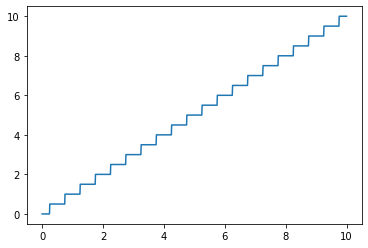

In [37]:
import numpy as np
import matplotlib.pyplot as plt

quantizing_bits     = 2
quantizing_levels   = 2 ** quantizing_bits / 2
q     = 1 / quantizing_levels
print(q)
#q = 0.5
x = np.linspace(0, 10, 1000)
y = q * np.round(x/q)
plt.plot(x,y)

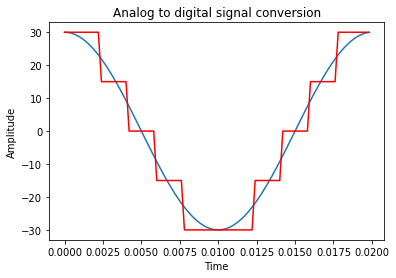

In [59]:
import numpy as np
import matplotlib.pyplot as plt

time_of_view        = 1.; # s.
analog_time         = np.linspace (0, time_of_view, 5000); # s.

sampling_rate       = 20.; # Hz
sampling_period     = 1. / sampling_rate; # s
sample_number       = np.int(np.round(time_of_view / sampling_period))
sampling_time       = np.linspace (0, time_of_view, sample_number);

carrier_frequency   = 50;
amplitude           = 30;
phase               = 0;

quantizing_bits     = 2;
quantizing_levels   = 2 ** quantizing_bits;
quantizing_step     = 60 / quantizing_levels;

def analog_signal (time_point):
    return amplitude * np.cos (2 * np.pi * carrier_frequency * time_point + phase);
sampling_signal     = analog_signal (analog_time);
#sampling_signal = VA_Filtered
quantizing_signal   = np.round (sampling_signal / quantizing_step) * quantizing_step;


fig = plt.figure ()
plt.plot (analog_time[0:100],   analog_signal(analog_time[0:100]) );
#plt.stem (sampling_time, sampling_signal);
#plt.stem (analog_time, quantizing_signal, linefmt='r-', markerfmt='rs', basefmt='r-');
plt.plot(analog_time[0:100], quantizing_signal[0:100], 'r-')
plt.title("Analog to digital signal conversion")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.show()

Los analogos V L1-N;V L2-N;V L3-N;I L1;I L2;I L3
Record has 4151 samples
Sampling rate is 5000 samples/sec.


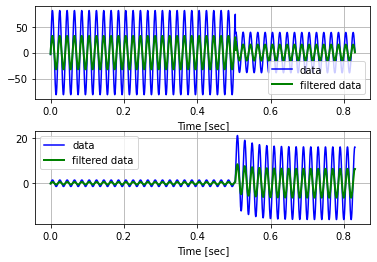

quantizing_step 0.057727499888502155
quantizing signal size [-0.115455   0.         0.         0.0577275  0.115455   0.115455
  0.1731825  0.23091    0.23091    0.2886375]


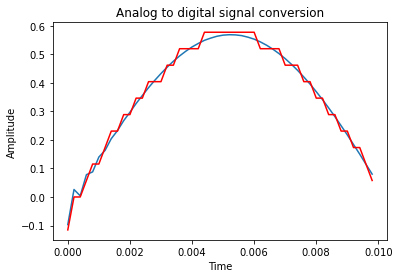

In [112]:
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 18 18:31:15 2020

@author: anavr
"""

import numpy as np
from scipy import signal, fftpack
from matplotlib import pyplot as plt
import pyComtrade
comtradeObj = pyComtrade.ComtradeRecord()
comtradeObj.read('./Comtrade TEST 1-1/L1L2L3_75%/BINAIRE/Test_1-1_ABC60_75%_BIN.cfg', './Comtrade TEST 1-1/L1L2L3_75%/BINAIRE/Test_1-1_ABC60_75%_BIN.dat')

print('Los analogos',comtradeObj.get_analog_ids())  # print the ids of the analog channels.

N = comtradeObj['endsamp'][-1]

print('Record has {} samples'.format(N))
print('Sampling rate is {} samples/sec.'.format(comtradeObj['samp'][-1]))

# Reading Phase A:
Voltage_A = comtradeObj['A'][0]['values']
Current_A = comtradeObj['A'][3]['values']

# Reading time vector:
time = comtradeObj.get_timestamps()

# Defining methods for the filter
def butter_lowpass(cutoff, fs, order):
    nyq = fs/2
    normal_cutoff = cutoff/nyq
    b,a = signal.butter(order, normal_cutoff, 'low', analog=True)
    return b,a

fk=50
# fs = np.ceil(1/cutoff * comtradeObj['samp'][-1])
fs = comtradeObj['samp'][-1]
cutoff = (fs-fk)/3
# fs = comtradeObj['samp'][-1]/50
order = 1
b,a = butter_lowpass(cutoff, fs, order)
# b,a = signal.butter(order, cutoff, 'low', analog=True)

w, h = signal.freqs(b, a)
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# plt.subplot(2,1,1)
# plt.title('Butterworth filter frequency response')
# plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
# # plt.semilogx(0.5*fs*w/np.pi, 20 * np.log10(abs(h)))
# plt.xlabel('Frequency [radians / second]')
# plt.ylabel('Amplitude [dB]')
# plt.margins(0, 0.1)
# plt.grid(which='both', axis='both')
# plt.axvline(cutoff, color='green') # cutoff frequency
# plt.tight_layout()

# zi = signal.lfilter_zi(b, a)
VA_Filtered = signal.lfilter(b,a,Voltage_A)
IA_Filtered = signal.lfilter(b,a,Current_A)

# print(VA_Filtered)
# print(len(Voltage_A))

plt.subplot(2, 1, 1)
plt.plot(time, Voltage_A, 'b-', label='data')
plt.plot(time, VA_Filtered, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, Current_A, 'b-', label='data')
plt.plot(time, IA_Filtered, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

# Quantizer - S&H and ADC
time_of_view        = time[-1]
sampling_rate_cycle = 2
sampling_rate       = sampling_rate_cycle*fk; # Hz
sampling_period     = 1 / sampling_rate; # s
sample_number       = np.int(np.round(time_of_view / sampling_period))
sampling_time       = np.linspace (0, time_of_view, sample_number)

quantizing_bits     = 8
quantizing_levels   = 2 ** quantizing_bits
quantizing_step     = (np.max(IA_Filtered)-np.min(IA_Filtered)) / quantizing_levels
#quantizing_step     = 2
print('quantizing_step', quantizing_step)

quantizing_signal   = np.round (IA_Filtered / quantizing_step) * quantizing_step;
print('quantizing signal size', quantizing_signal[0:10])

fig = plt.figure ()
plt.plot (time[0:50],  IA_Filtered[0:50]  );
#plt.stem (sampling_time, sampling_signal);
#plt.stem (time[0:50], quantizing_signal[0:50], linefmt='r-', markerfmt='rs', basefmt='r-');
plt.plot(time[0:50], quantizing_signal[0:50], 'r-')
plt.title("Analog to digital signal conversion")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.show()

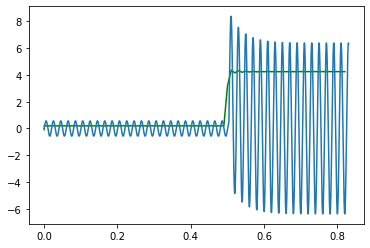

In [118]:
# time, quantizing_signal: These are the vectors for the digital signal
fs_cycle = fs/fk
N=np.int(fs_cycle/2)
N_tot = np.int(len(quantizing_signal)/N)
Xc = [0]*N_tot
Xs = [0]*N_tot
t = [0]*N_tot

#print(N)
for i in np.arange(N_tot):
    xi=quantizing_signal[i*N:i*N+N]
    t[i]=time[i*N]
    Xc_sum = 0
    Xs_sum = 0
    for k in np.arange(N):
        Xc_temp=xi[k]*np.cos(2*np.pi*k/N)
        Xc_sum=Xc_sum+Xc_temp
        Xs_temp=xi[k]*np.sin(2*np.pi*k/N)
        Xs_sum=Xs_sum+Xs_temp
        
    Xc[i]= -np.pi/(2*N)*Xc_sum
    Xs[i]= np.pi/(2*N)* Xs_sum

X = np.sqrt(np.power(Xc,2)+np.power(Xs,2))
plt.plot (t,  X, 'g-');
plt.plot (time,  IA_Filtered  );

In [77]:
i=0
N=100
quantizing_signal[i*N:i*N+(N-1)]

array([ -4.03874441,   4.03874441,   4.03874441,   4.03874441,
         8.07748883,   8.07748883,  12.11623324,  12.11623324,
        16.15497766,  16.15497766,  20.19372207,  20.19372207,
        20.19372207,  24.23246649,  24.23246649,  24.23246649,
        28.2712109 ,  28.2712109 ,  28.2712109 ,  28.2712109 ,
        32.30995532,  32.30995532,  32.30995532,  32.30995532,
        32.30995532,  32.30995532,  32.30995532,  32.30995532,
        32.30995532,  32.30995532,  32.30995532,  32.30995532,
        28.2712109 ,  28.2712109 ,  28.2712109 ,  28.2712109 ,
        24.23246649,  24.23246649,  24.23246649,  20.19372207,
        20.19372207,  16.15497766,  16.15497766,  16.15497766,
        12.11623324,  12.11623324,   8.07748883,   8.07748883,
         4.03874441,   4.03874441,   0.        ,  -0.        ,
        -4.03874441,  -4.03874441,  -8.07748883,  -8.07748883,
       -12.11623324, -12.11623324, -16.15497766, -16.15497766,
       -20.19372207, -20.19372207, -20.19372207, -24.23

In [88]:
Xc[10]


-0.25662200652938083